Imports

In [1]:
from Dataset import processData
import os
from Model import train, quick_train, KGLinkPredictor
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

Process Data and Save for Later

In [2]:
embedding_dim = 768
batch_size = 16384
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If no data has been processed yet, process the data and save it
if not os.path.exists(f'processed_data/E{embedding_dim}'):
    
    data, ptrain_loader, pval_loader,ftrain_loader, fval_loader, ftest_loader, kg = processData(embedding_dim,batch_size,'ourkg_raw_updated+.csv',device)
    path = f'processed_data/E{embedding_dim}'
    os.mkdir(path)
    
    torch.save(data, os.path.join(path, 'data_obj.pt'))
    torch.save(ptrain_loader, os.path.join(path, 'ptrain_loader.pt'))
    torch.save(pval_loader, os.path.join(path, 'pval_loader.pt'))
    torch.save(ftrain_loader, os.path.join(path, 'ftrain_loader.pt'))
    torch.save(fval_loader, os.path.join(path, 'fval_loader.pt'))
    torch.save(ftest_loader, os.path.join(path, 'ftest_loader.pt'))
    torch.save(kg, os.path.join(path, 'kg.pt'))

# Use previously processed data
else:
    data = torch.load(f'processed_data/E{embedding_dim}/data_obj.pt')
    ptrain_loader = torch.load(f'processed_data/E{embedding_dim}/ptrain_loader.pt')
    pval_loader = torch.load(f'processed_data/E{embedding_dim}/pval_loader.pt')
    ftrain_loader = torch.load(f'processed_data/E{embedding_dim}/ftrain_loader.pt')
    fval_loader = torch.load(f'processed_data/E{embedding_dim}/fval_loader.pt')
    ftest_loader = torch.load(f'processed_data/E{embedding_dim}/ftest_loader.pt')
    kg = torch.load(f'processed_data/E{embedding_dim}/kg.pt')

Declare and Train Model (ONLY IF MODEL HAS NOT BEEN TRAINED AND SAVED YET)

In [4]:
hidden_dim = 128
model = KGLinkPredictor(embedding_dim,hidden_dim,data,device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = data.to(device)

print('Pretraining...')
quick_train(ptrain_loader, model, optimizer, device, 1)

model.Decoder.reset_parameters()

print('Fine-tuning...')
quick_train(ftrain_loader, model, optimizer, device, 50)

Pretraining...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 0.2575534704944183
Fine-tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 1.111975610256195
Epoch 2 | Average Training Loss: 0.7777909636497498
Epoch 3 | Average Training Loss: 0.6301854054133097
Epoch 4 | Average Training Loss: 0.5874600013097128
Epoch 5 | Average Training Loss: 0.540143628915151
Epoch 6 | Average Training Loss: 0.49983274936676025
Epoch 7 | Average Training Loss: 0.45288804173469543
Epoch 8 | Average Training Loss: 0.40119604269663495
Epoch 9 | Average Training Loss: 0.35144104560216266
Epoch 10 | Average Training Loss: 0.30887657403945923
Epoch 11 | Average Training Loss: 0.27176131804784137
Epoch 12 | Average Training Loss: 0.23780417939027151
Epoch 13 | Average Training Loss: 0.21032254894574484
Epoch 14 | Average Training Loss: 0.1932239830493927
Epoch 15 | Average Training Loss: 0.18051997820536295
Epoch 16 | Average Training Loss: 0.1620632161696752
Epoch 17 | Average Training Loss: 0.15727689365545908
Epoch 18 | Average Training Loss: 0.153860941529274
Epoch 19 | Average Training Loss: 0.143751000364

KeyboardInterrupt: 

Save Model

In [5]:
torch.save(model.state_dict(), 'models/TestModel.pt')

Load Model (CURRENTLY NONFUNCTIONAL)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = torch.load(r'processed_data/E256/data_obj.pt').to(device)
model = KGLinkPredictor(256,64,data).to(device)
model.load_state_dict(torch.load(r'models/TestModel.pt'))

<All keys matched successfully>

Evaluate

In [6]:
indication_true = np.array([])
indication_pred = np.array([])

contraindication_true = np.array([])
contraindication_pred = np.array([])

for batch in fval_loader:
    
    contraindication = batch[batch[:,1] == 5]
    indication = batch[batch[:,1] == 6]
    
    contra_head,contra_rel,contra_tail = contraindication[:,0],contraindication[:,1],contraindication[:,2]
    contra_head,contra_rel,contra_tail = contra_head.to(device),contra_rel.to(device),contra_tail.to(device)
    
    indi_head,indi_rel,indi_tail = indication[:,0],indication[:,1],indication[:,2]
    indi_head,indi_rel,indi_tail = indi_head.to(device),indi_rel.to(device),indi_tail.to(device)
    
    contraindication_true = np.append(contraindication_true,len(contraindication)*[1])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(contra_head,contra_rel,contra_tail)).detach().cpu().numpy().flatten())
    contraindication_true = np.append(contraindication_true,len(contraindication)*[0])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(contra_head, contra_rel, contra_tail), loss_tag=False)).detach().cpu().numpy().flatten())
    
    indication_true = np.append(indication_true,len(indication)*[1])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(indi_head,indi_rel,indi_tail)).detach().cpu().numpy().flatten())
    indication_true = np.append(indication_true,len(indication)*[0])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(indi_head, indi_rel, indi_tail), loss_tag=False)).detach().cpu().numpy().flatten())

Plot ROC curves

Indication AUC: 0.9232882968002016
Contraindication AUC: 0.9452738249771643


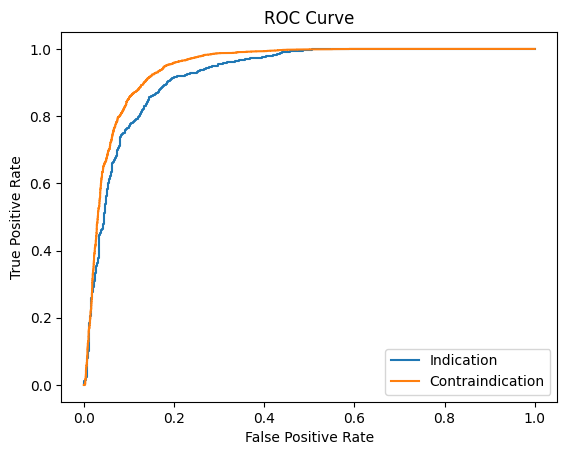

In [7]:
def plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred):
    """
    plots the roc curve based of the probabilities
    """

    i_fpr, i_tpr, thresholds = roc_curve(indication_true, indication_pred)
    c_fpr, c_tpr, thresholds = roc_curve(contraindication_true, contraindication_pred)
    plt.plot(i_fpr, i_tpr)
    plt.plot(c_fpr, c_tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(['Indication','Contraindication'])

plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred)

print('Indication AUC:',roc_auc_score(indication_true, indication_pred))
print('Contraindication AUC:',roc_auc_score(contraindication_true, contraindication_pred))

Find optimal threshold for f1 score

In [8]:
contraindication_thresholds = []
indication_thresholds = []
for thresh in range(-45,50,1):
    thresh = thresh/100
    contraindication_pred_mod = np.round(contraindication_pred-thresh)
    indication_pred_mod = np.round(indication_pred-thresh)
    
    contraindication_thresholds.append(f1_score(contraindication_true, contraindication_pred_mod))
    indication_thresholds.append(f1_score(indication_true, indication_pred_mod))

contraindication_threshold = round((contraindication_thresholds.index(max(contraindication_thresholds)) - 45) / 100,2)
indication_threshold = round((indication_thresholds.index(max(indication_thresholds)) - 45) / 100,2)

Show confusion matrices

In [9]:
print(f'Indication: \n{confusion_matrix(indication_true, np.round(indication_pred-indication_threshold))}\n')
print(f'Contraindication: \n{confusion_matrix(contraindication_true, np.round(contraindication_pred-contraindication_threshold))}')

Indication: 
[[812 196]
 [ 87 921]]

Contraindication: 
[[2784  615]
 [ 171 3228]]


Apply to our diseases

In [10]:
our_diseases = ['HeV_Astro','HeV_Neuron','MIGs','minor spliceosome','NiV_M_Astro','NiV_M_Neuron','NiV_B_Astro','NiV_B_Neuron']

In [11]:
indication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))
contraindication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))

for i,disease in enumerate(our_diseases):
    x_index = kg[(kg['x_type']=='disease') & (kg['x_name']==disease)]['x_index'].unique()[0]
    
    contraindication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*4
    indication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*5
    drug = torch.arange(0,data['drug'].num_nodes,dtype=torch.long)
    query_disease = torch.ones(data['drug'].num_nodes,dtype=torch.long)*x_index
    
    indication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,indication,drug)).detach().cpu().numpy().flatten()
    contraindication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,contraindication,drug)).detach().cpu().numpy().flatten()

No drug in our network reaches a viable indication or contraindication threshold

In [12]:
for i,disease in enumerate(our_diseases):
    print(disease)
    print(f'Max Indication: {round(max(indication_predictions[i]),2)} | Threshold: {round(0.5 + indication_threshold,2)}')
    print(f'Max Contraindication: {round(max(contraindication_predictions[i]),2)} | Threshold: {round(0.5 + contraindication_threshold,2)}\n')

HeV_Astro
Max Indication: 0.03 | Threshold: 0.05
Max Contraindication: 0.23 | Threshold: 0.11

HeV_Neuron
Max Indication: 0.04 | Threshold: 0.05
Max Contraindication: 0.26 | Threshold: 0.11

MIGs
Max Indication: 0.22 | Threshold: 0.05
Max Contraindication: 0.39 | Threshold: 0.11

minor spliceosome
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 0.01 | Threshold: 0.11

NiV_M_Astro
Max Indication: 0.09 | Threshold: 0.05
Max Contraindication: 0.32 | Threshold: 0.11

NiV_M_Neuron
Max Indication: 0.03 | Threshold: 0.05
Max Contraindication: 0.24 | Threshold: 0.11

NiV_B_Astro
Max Indication: 0.02 | Threshold: 0.05
Max Contraindication: 0.2 | Threshold: 0.11

NiV_B_Neuron
Max Indication: 0.02 | Threshold: 0.05
Max Contraindication: 0.2 | Threshold: 0.11



Save scores for later use

In [13]:
torch.save(indication_predictions, 'indication_predictions++.pt')
torch.save(contraindication_predictions, 'contraindication_predictions++.pt')

In [ ]:
indication_predictions = torch.load('indication_predictions++.pt')
contraindication_predictions = torch.load('contraindication_predictions++.pt')

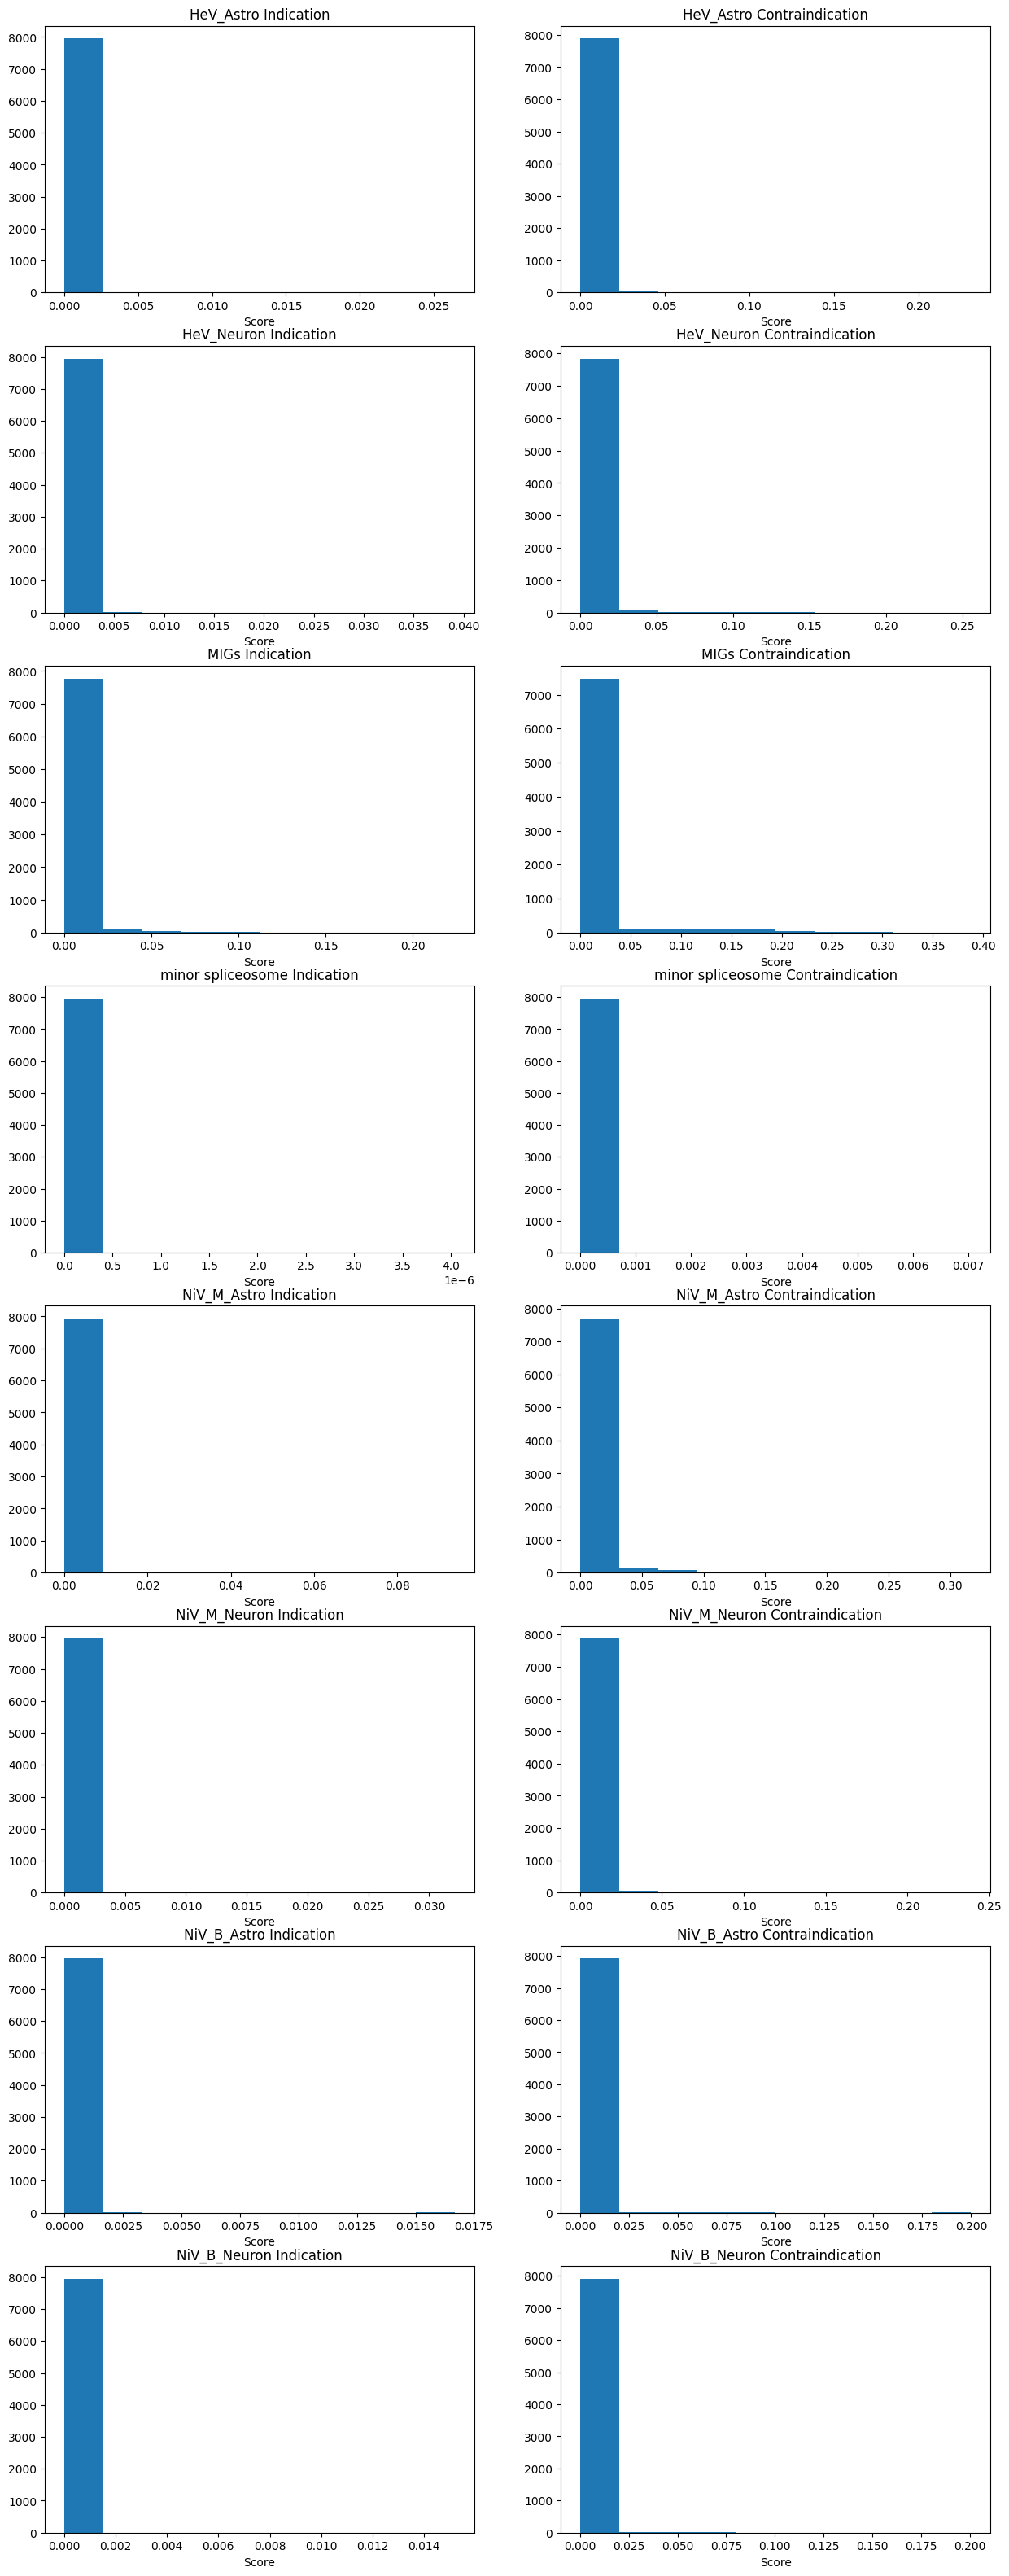

In [14]:
diseases = ['HeV_Astro','HeV_Neuron','MIGs','minor spliceosome','NiV_M_Astro','NiV_M_Neuron','NiV_B_Astro','NiV_B_Neuron']

ax,fig = plt.subplots(len(diseases),2,figsize=(15,40))
for i,disease in enumerate(contraindication_predictions):
    
    fig[i,0].hist(indication_predictions[i],bins=10)
    fig[i,0].set_title(f'{diseases[i]} Indication')
    fig[i,0].set_xlabel('Score')
    
    fig[i,1].hist(contraindication_predictions[i],bins=10)
    fig[i,1].set_title(f'{diseases[i]} Contraindication')
    fig[i,1].set_xlabel('Score')
        
plt.show()